In [1]:
import iris
import numpy
import cf_units
import matplotlib.pyplot as plt

In [2]:
ghg_file = '/g/data/r87/dbi599/DRSv2/CMIP5/CSIRO-Mk3-6-0/historicalGHG/yr/all/r1i1p1/energy-budget/latest/energy-budget_yr_CSIRO-Mk3-6-0_historicalGHG_r1i1p1_all.nc'
aa_file = '/g/data/r87/dbi599/DRSv2/CMIP5/CSIRO-Mk3-6-0/historicalMisc/yr/all/r1i1p4/energy-budget/latest/energy-budget_yr_CSIRO-Mk3-6-0_historicalMisc_r1i1p4_all.nc'

In [3]:
def convert_to_seconds(time_axis):
    """Convert time axis units to seconds.
    Args:
      time_axis(iris.DimCoord)
    """

    old_units = str(time_axis.units)
    old_timestep = old_units.split(' ')[0]
    new_units = old_units.replace(old_timestep, 'seconds') 

    new_unit = cf_units.Unit(new_units, calendar=time_axis.units.calendar)  
    time_axis.convert_units(new_unit)

    return time_axis


def _linear_trend(data, time_axis):
    """Calculate the linear trend.
    polyfit returns [a, b] corresponding to y = a + bx
    """    

    masked_flag = False

    if type(data) == numpy.ma.core.MaskedArray:
        if type(data.mask) == numpy.bool_:
            if data.mask:
                masked_flag = True
        elif data.mask[0]:
            masked_flag = True
            
    if masked_flag:
        return data.fill_value
    else:
        return numpy.polynomial.polynomial.polyfit(time_axis, data, 1)[-1]

    
def undo_unit_scaling(cube):
    """Remove scale factor from input data.
    e.g. Ocean heat content data will often have units like 10^12 J m-2.
    Args:
      cube (iris.cube.Cube)
    """

    units = str(cube.units)

    if '^' in units:
        scaling = units.split(' ')[0]
        factor = float(scaling.split('^')[-1])
        cube = cube * 10**factor
    else:
        pass

    return cube


def calc_trend(cube, running_mean=False, per_yr=False, remove_scaling=False):
    """Calculate linear trend.
    Args:
      cube (iris.cube.Cube)
      running_mean(bool, optional): 
        A 12-month running mean can first be applied to the data
      yr (bool, optional):
        Change units from per second to per year
    """

    coord_names = [coord.name() for coord in cube.dim_coords]
    assert coord_names[0] == 'time'

    if remove_scaling:
        cube = undo_unit_scaling(cube)

    if running_mean:
        cube = cube.rolling_window('time', iris.analysis.MEAN, 12)

    time_axis = cube.coord('time')
    time_axis = convert_to_seconds(time_axis)

    trend = numpy.ma.apply_along_axis(_linear_trend, 0, cube.data, time_axis.points)
    if type(cube.data) == numpy.ma.core.MaskedArray:
        trend = numpy.ma.masked_values(trend, cube.data.fill_value)

    if per_yr:
        trend = trend * 60 * 60 * 24 * 365.25

    return trend

In [4]:
ghg_rnds_globe_cube = iris.load_cube(ghg_file, 'Surface Downwelling Net Radiation globe sum')
aa_rnds_globe_cube = iris.load_cube(aa_file, 'Surface Downwelling Net Radiation globe sum')

ghg_rnds_globe_trend = calc_trend(ghg_rnds_globe_cube, per_yr=True)
aa_rnds_globe_trend = calc_trend(aa_rnds_globe_cube, per_yr=True)

/g/data/r87/dbi599/miniconda3/envs/ocean/lib/python3.6/site-packages/iris/fileformats/cf.py:1143: IrisDeprecation: NetCDF default loading behaviour currently does not expose variables which define reference surfaces for dimensionless vertical coordinates as independent Cubes. This behaviour is deprecated in favour of automatic promotion to Cubes. To switch to the new behaviour, set iris.FUTURE.netcdf_promote to True.
  warn_deprecated(msg)
/g/data/r87/dbi599/miniconda3/envs/ocean/lib/python3.6/site-packages/iris/fileformats/cf.py:1143: IrisDeprecation: NetCDF default loading behaviour currently does not expose variables which define reference surfaces for dimensionless vertical coordinates as independent Cubes. This behaviour is deprecated in favour of automatic promotion to Cubes. To switch to the new behaviour, set iris.FUTURE.netcdf_promote to True.
  warn_deprecated(msg)


In [14]:
print(ghg_rnds_globe_trend)
print(aa_rnds_globe_trend)
print((ghg_rnds_globe_trend / aa_rnds_globe_trend) * 100)

5.6826277752e+12
-9.50683510175e+12
-59.7741279235


In [5]:
rlus_ghg_values = []
rlus_aa_values = []
hfls_ghg_values = []
hfls_aa_values = []
hfds_ghg_values = []
hfds_aa_values = []
for region in ['ssubpolar', 'stropics', 'ntropics', 'nsubpolar', 'arctic']:
    rlus_var = 'Surface Upwelling Longwave Radiation %s ocean sum'  %(region)
    hfls_var = 'Surface Upward Latent Heat Flux %s ocean sum' %(region)
    hfds_var = 'Downward Heat Flux at Sea Water Surface %s ocean sum' %(region)
    
    rlus_ghg_cube = iris.load_cube(ghg_file, rlus_var)
    rlus_aa_cube = iris.load_cube(aa_file, rlus_var)
    rlus_ghg_values.append(calc_trend(rlus_ghg_cube, per_yr=True) / ghg_rnds_globe_trend)
    rlus_aa_values.append(calc_trend(rlus_aa_cube, per_yr=True) / aa_rnds_globe_trend)
    
    hfls_ghg_cube = iris.load_cube(ghg_file, hfls_var)
    hfls_aa_cube = iris.load_cube(aa_file, hfls_var)
    hfls_ghg_values.append(calc_trend(hfls_ghg_cube, per_yr=True) / ghg_rnds_globe_trend)
    hfls_aa_values.append(calc_trend(hfls_aa_cube, per_yr=True) / aa_rnds_globe_trend)
    
    hfds_ghg_cube = iris.load_cube(ghg_file, hfds_var)
    hfds_aa_cube = iris.load_cube(aa_file, hfds_var)
    hfds_ghg_values.append(calc_trend(hfds_ghg_cube, per_yr=True) / ghg_rnds_globe_trend)
    hfds_aa_values.append(calc_trend(hfds_aa_cube, per_yr=True) / aa_rnds_globe_trend)

/g/data/r87/dbi599/miniconda3/envs/ocean/lib/python3.6/site-packages/iris/fileformats/cf.py:1143: IrisDeprecation: NetCDF default loading behaviour currently does not expose variables which define reference surfaces for dimensionless vertical coordinates as independent Cubes. This behaviour is deprecated in favour of automatic promotion to Cubes. To switch to the new behaviour, set iris.FUTURE.netcdf_promote to True.
  warn_deprecated(msg)
/g/data/r87/dbi599/miniconda3/envs/ocean/lib/python3.6/site-packages/iris/fileformats/cf.py:1143: IrisDeprecation: NetCDF default loading behaviour currently does not expose variables which define reference surfaces for dimensionless vertical coordinates as independent Cubes. This behaviour is deprecated in favour of automatic promotion to Cubes. To switch to the new behaviour, set iris.FUTURE.netcdf_promote to True.
  warn_deprecated(msg)
/g/data/r87/dbi599/miniconda3/envs/ocean/lib/python3.6/site-packages/iris/fileformats/cf.py:1143: IrisDeprecatio

In [27]:
% matplotlib inline

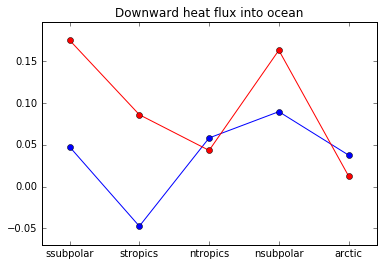

In [8]:
xvals = [1, 2, 3, 4, 5]
labels = ['ssubpolar', 'stropics', 'ntropics', 'nsubpolar', 'arctic']
plt.plot(xvals, hfds_aa_values, 'o-', color='blue', label='AA')
plt.plot(xvals, hfds_ghg_values, 'o-', color='red', label='GHG')
plt.xticks(xvals, labels)
plt.margins(0.1)
plt.title('Downward heat flux into ocean')
plt.show()

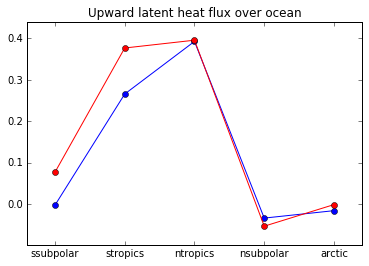

In [9]:
xvals = [1, 2, 3, 4, 5]
labels = ['ssubpolar', 'stropics', 'ntropics', 'nsubpolar', 'arctic']
plt.plot(xvals, hfls_aa_values, 'o-', color='blue', label='AA')
plt.plot(xvals, hfls_ghg_values, 'o-', color='red', label='GHG')
plt.xticks(xvals, labels)
plt.margins(0.1)
plt.title('Upward latent heat flux over ocean')
plt.show()

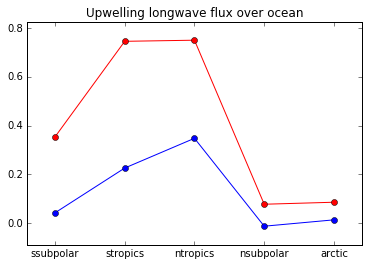

In [10]:
xvals = [1, 2, 3, 4, 5]
labels = ['ssubpolar', 'stropics', 'ntropics', 'nsubpolar', 'arctic']
plt.plot(xvals, rlus_aa_values, 'o-', color='blue', label='AA')
plt.plot(xvals, rlus_ghg_values, 'o-', color='red', label='GHG')
plt.xticks(xvals, labels)
plt.margins(0.1)
plt.title('Upwelling longwave flux over ocean')
plt.show()